In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sns.set(style='whitegrid')

In [3]:
user_data = pd.read_json("Data/user.json")

In [4]:
split_data = pd.read_csv("Data/split.csv")
label_data = pd.read_csv("Data/label.csv")

In [5]:
split_data['split'].value_counts(normalize=True)

split
train    0.7
val      0.2
test     0.1
Name: proportion, dtype: float64

In [6]:
train_ids = split_data[split_data['split']=='train']['id']
val_ids = split_data[split_data['split']=='val']['id']
test_ids = split_data[split_data['split']=='test']['id']

In [7]:
user_data_with_label = pd.merge(user_data,label_data,on='id')

In [8]:
user_train_df = user_data_with_label[user_data_with_label['id'].isin(train_ids)]

In [9]:
user_train_df.head(5)

,created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified,withheld,label
1,2014-07-02 17:56:46+00:00,creative _,None,u2664730894,🎈,olawale 💨,NaN,https://pbs.twimg.com/profile_images/147837638...,False,"{'followers_count': 123, 'following_count': 10...",,wale_io,False,None,human
3,2019-01-26 13:52:49+00:00,mama to maya. ABIM research pathway fellow @UV...,"{'description': {'mentions': [{'start': 43, 'e...",u1089159225148882949,"Charlottesville, VA","Jacqueline Hodges, MD MPH",NaN,https://pbs.twimg.com/profile_images/130229171...,False,"{'followers_count': 350, 'following_count': 57...",,jachodges_md,False,None,human
4,2009-04-30 19:01:42+00:00,Father / SWT Alumnus / Longhorn Fan,None,u36741729,United States,Matthew Stubblefield,NaN,https://pbs.twimg.com/profile_images/145808462...,True,"{'followers_count': 240, 'following_count': 29...",,Matthew_Brody,False,None,bot
6,2013-08-18 04:21:48+00:00,,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",u1679822588,🇬🇧,Grian,1.143808e+18,https://pbs.twimg.com/profile_images/100773461...,False,"{'followers_count': 238254, 'following_count':...",https://t.co/V3FyRYAsvK,GrianMC,False,None,bot
7,2013-06-15 11:34:55+00:00,The hottest brownboy in the game. ...,None,u1519144464,"Umhlanga, South Africa",Nikhil Sewdass,NaN,https://pbs.twimg.com/profile_images/146310691...,False,"{'followers_count': 161, 'following_count': 27...",,NikhilSewdass,False,None,human


In [10]:
label_counts = user_train_df['label'].value_counts()
colors = sns.color_palette("pastel")[0:2]

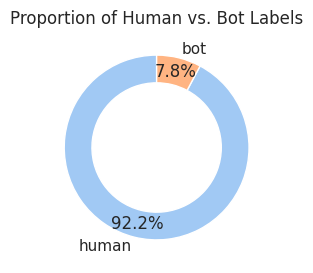

In [11]:
plt.figure(figsize=(4, 3))
plt.pie(
    label_counts,
    labels=label_counts.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops=dict(width=0.3, edgecolor='w')
)

# Adding a circle at the center to create the donut shape
center_circle = plt.Circle((0, 0), 0.3, color='white')
plt.gca().add_artist(center_circle)

# Set title and display
plt.title("Proportion of Human vs. Bot Labels")
plt.show()


In [12]:
user_features = pd.DataFrame(user_train_df[['id','label']])

In [13]:
current_date = datetime.now(pytz.UTC)

In [14]:
user_features['account_age'] = user_train_df['created_at'].apply(lambda x: (current_date - x).days / 365.25)
user_features['account_age'] = user_features['account_age'].apply(lambda x: np.nan if x > 18 else x)
user_features['account_age'] = user_features.groupby('label')['account_age'].transform(lambda grp: grp.fillna(grp.mean()))

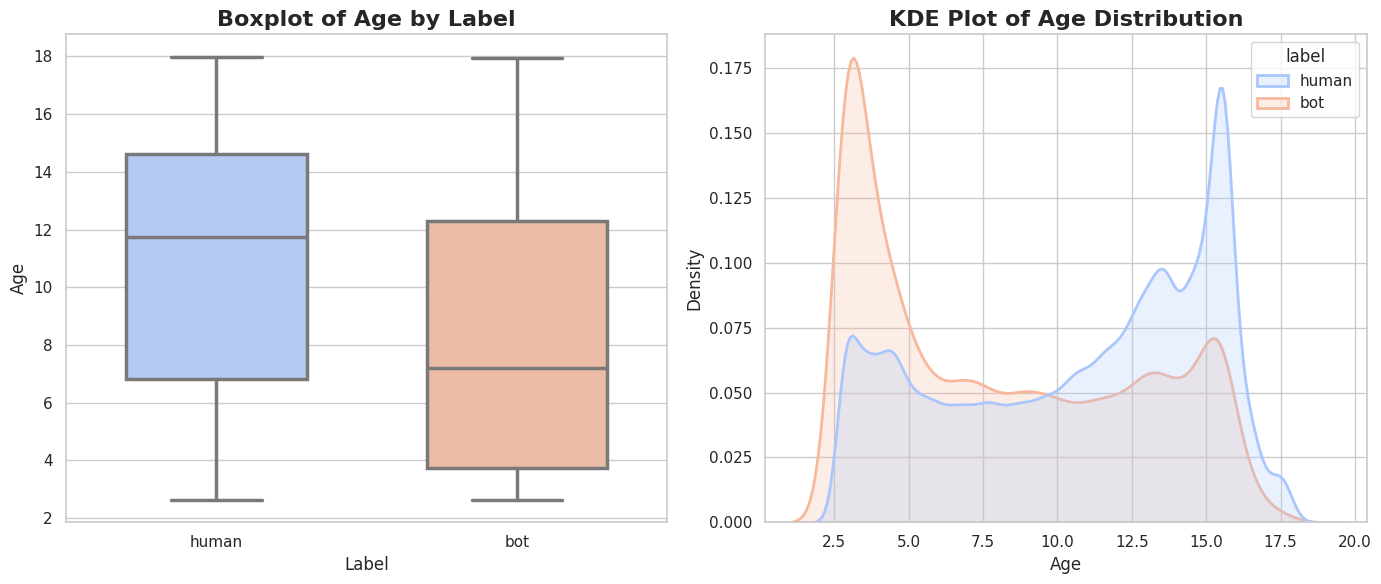

In [15]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot on the left (with labels)
sns.boxplot(x='label', y='account_age', data=user_features, palette="coolwarm", width=0.6, linewidth=2.5, ax=axes[0])
axes[0].set_title('Boxplot of Age by Label', fontsize=16, weight='bold')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Age', fontsize=12)

# KDE plot on the right (distribution of age without labels)
sns.kdeplot(data=user_features, x='account_age', hue='label', fill=True, common_norm=False, palette="coolwarm", linewidth=2, ax=axes[1])
axes[1].set_title('KDE Plot of Age Distribution', fontsize=16, weight='bold')
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [16]:
user_features['followers_count'] = user_train_df['public_metrics'].apply(lambda x: x.get('followers_count', 0))
user_features['following_count'] = user_train_df['public_metrics'].apply(lambda x: x.get('following_count', 0))
user_features['tweet_count'] = user_train_df['public_metrics'].apply(lambda x: x.get('tweet_count', 0))
user_features['listed_count'] = user_train_df['public_metrics'].apply(lambda x: x.get('listed_count', 0))

In [17]:
user_features['log_followers_count'] = np.log1p(user_features['followers_count'])
user_features['log_following_count'] = np.log1p(user_features['following_count'])
user_features['log_tweet_count'] = np.log1p(user_features['tweet_count'])
user_features['log_listed_count'] = np.log1p(user_features['listed_count'])

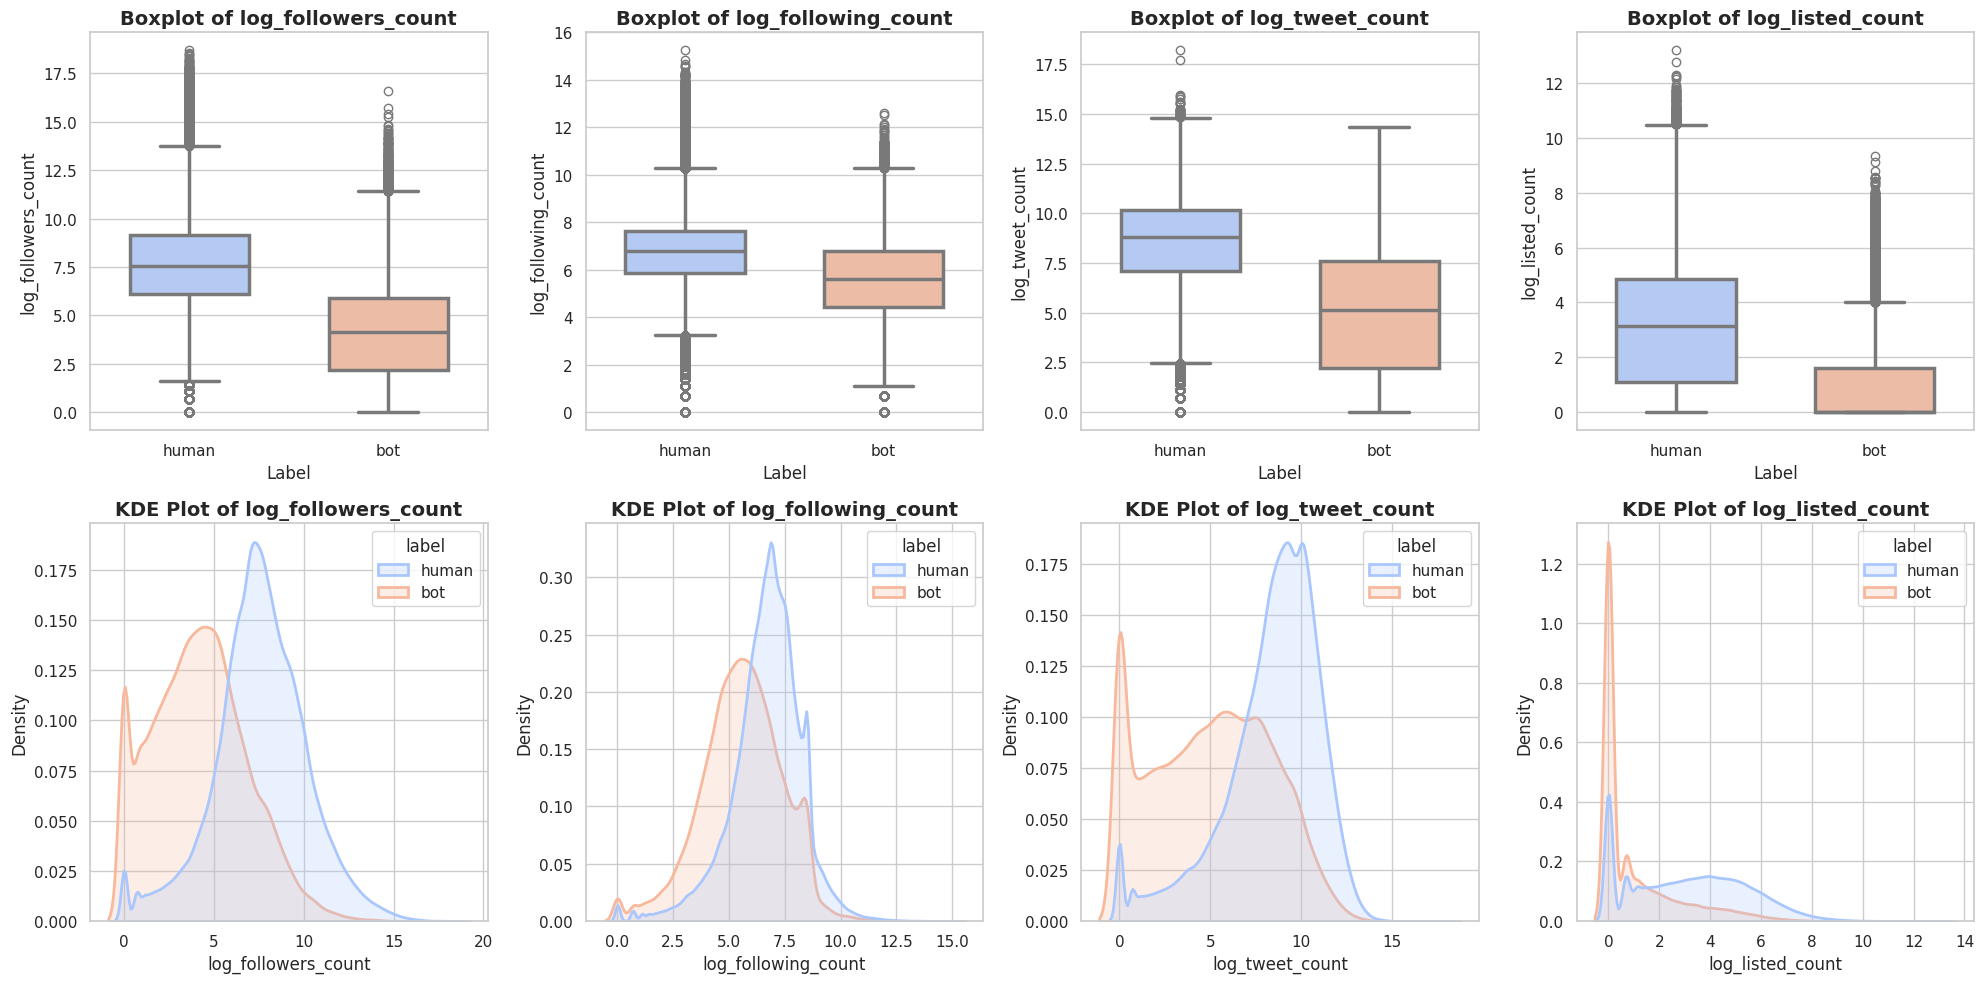

In [18]:
# Define the metrics to visualize
metrics = ['log_followers_count', 'log_following_count', 'log_tweet_count', 'log_listed_count']

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through metrics to create boxplots and KDE plots
for i, metric in enumerate(metrics):
    # Boxplot
    sns.boxplot(x='label', y=metric, data=user_features, palette="coolwarm", width=0.6, linewidth=2.5, ax=axes[0, i])
    axes[0, i].set_title(f'Boxplot of {metric}', fontsize=14, weight='bold')
    axes[0, i].set_xlabel('Label', fontsize=12)
    axes[0, i].set_ylabel(metric, fontsize=12)

    # KDE plot
    sns.kdeplot(data=user_features, x=metric, hue='label', fill=True, common_norm=False, palette="coolwarm", linewidth=2, ax=axes[1, i])
    axes[1, i].set_title(f'KDE Plot of {metric}', fontsize=14, weight='bold')
    axes[1, i].set_xlabel(metric, fontsize=12)
    axes[1, i].set_ylabel('Density', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [19]:
user_features['follower_following_ratio'] = user_features['followers_count'] / (user_features['following_count'] + 1)
user_features['log_follower_following_ratio'] = np.log1p(user_features['follower_following_ratio'])

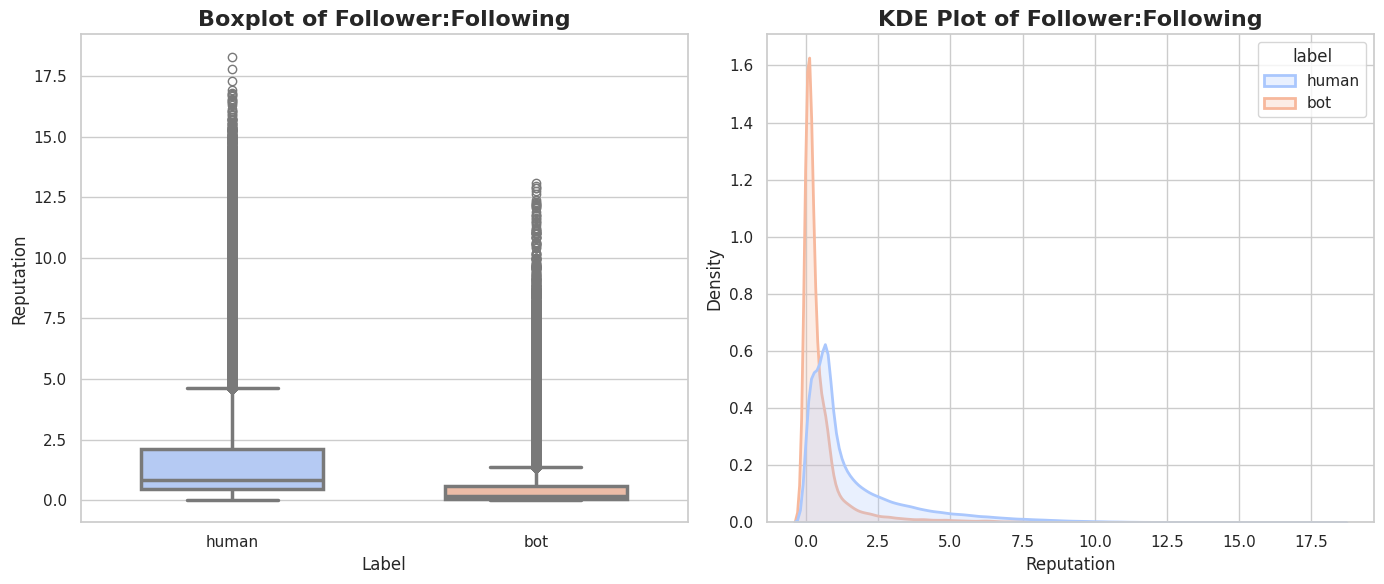

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot on the left (with labels)
sns.boxplot(x='label', y='log_follower_following_ratio', data=user_features, palette="coolwarm", width=0.6, linewidth=2.5, ax=axes[0])
axes[0].set_title('Boxplot of Follower:Following', fontsize=16, weight='bold')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Reputation', fontsize=12)

# KDE plot on the right (distribution of age without labels)
sns.kdeplot(data=user_features, x='log_follower_following_ratio', hue='label', fill=True, common_norm=False, palette="coolwarm", linewidth=2, ax=axes[1])
axes[1].set_title('KDE Plot of Follower:Following', fontsize=16, weight='bold')
axes[1].set_xlabel('Reputation', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [21]:
user_features['is_verified'] = user_train_df['verified'].astype(int)
user_features['is_private'] = user_train_df['protected'].astype(int)

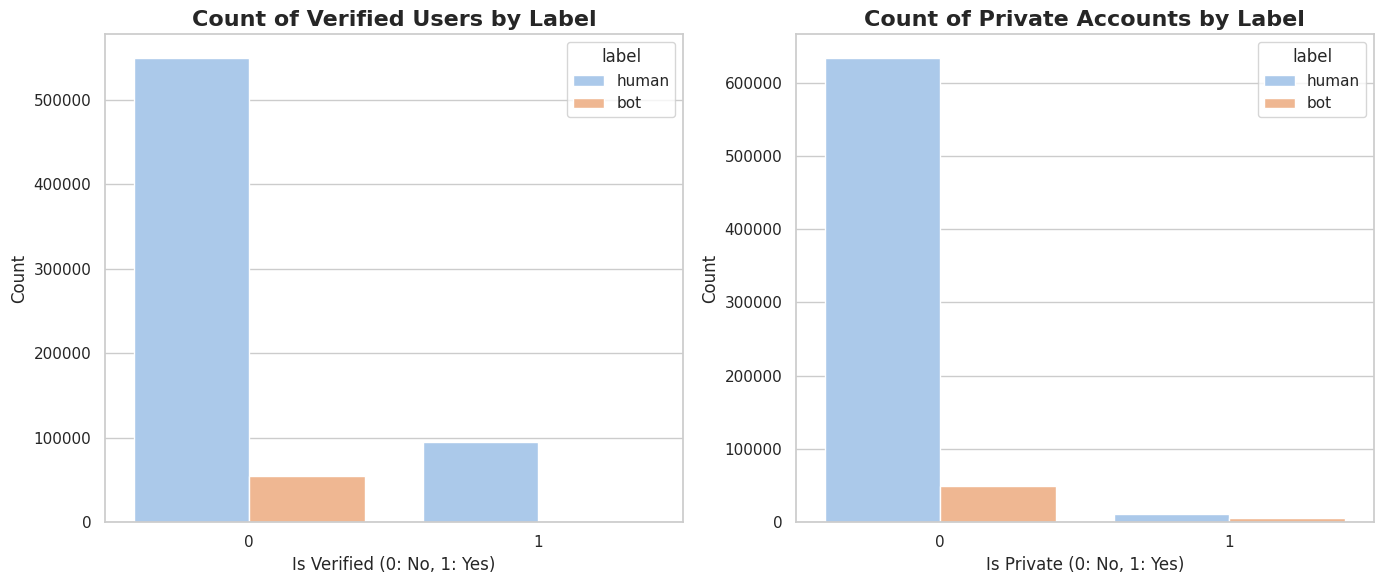

In [22]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Countplot for 'is_verified'
sns.countplot(x='is_verified', hue='label', data=user_features, palette="pastel", ax=axes[0])
axes[0].set_title('Count of Verified Users by Label', fontsize=16, weight='bold')
axes[0].set_xlabel('Is Verified (0: No, 1: Yes)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Countplot for 'is_private'
sns.countplot(x='is_private', hue='label', data=user_features, palette="pastel", ax=axes[1])
axes[1].set_title('Count of Private Accounts by Label', fontsize=16, weight='bold')
axes[1].set_xlabel('Is Private (0: No, 1: Yes)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [23]:
user_features['tweet_rate_daily'] = user_features['tweet_count'] / (user_features['account_age'] * 365.25)
user_features['tweet_rate_weekly'] = user_features['tweet_count'] / (user_features['account_age'] * 52)
user_features['tweet_rate_monthly'] = user_features['tweet_count'] / (user_features['account_age'] * 12)

In [24]:
user_features['log_tweet_rate_daily'] = np.log1p(user_features['tweet_rate_daily'])  # log(1 + x)
user_features['log_tweet_rate_weekly'] = np.log1p(user_features['tweet_rate_weekly'])
user_features['log_tweet_rate_monthly'] = np.log1p(user_features['tweet_rate_monthly'])

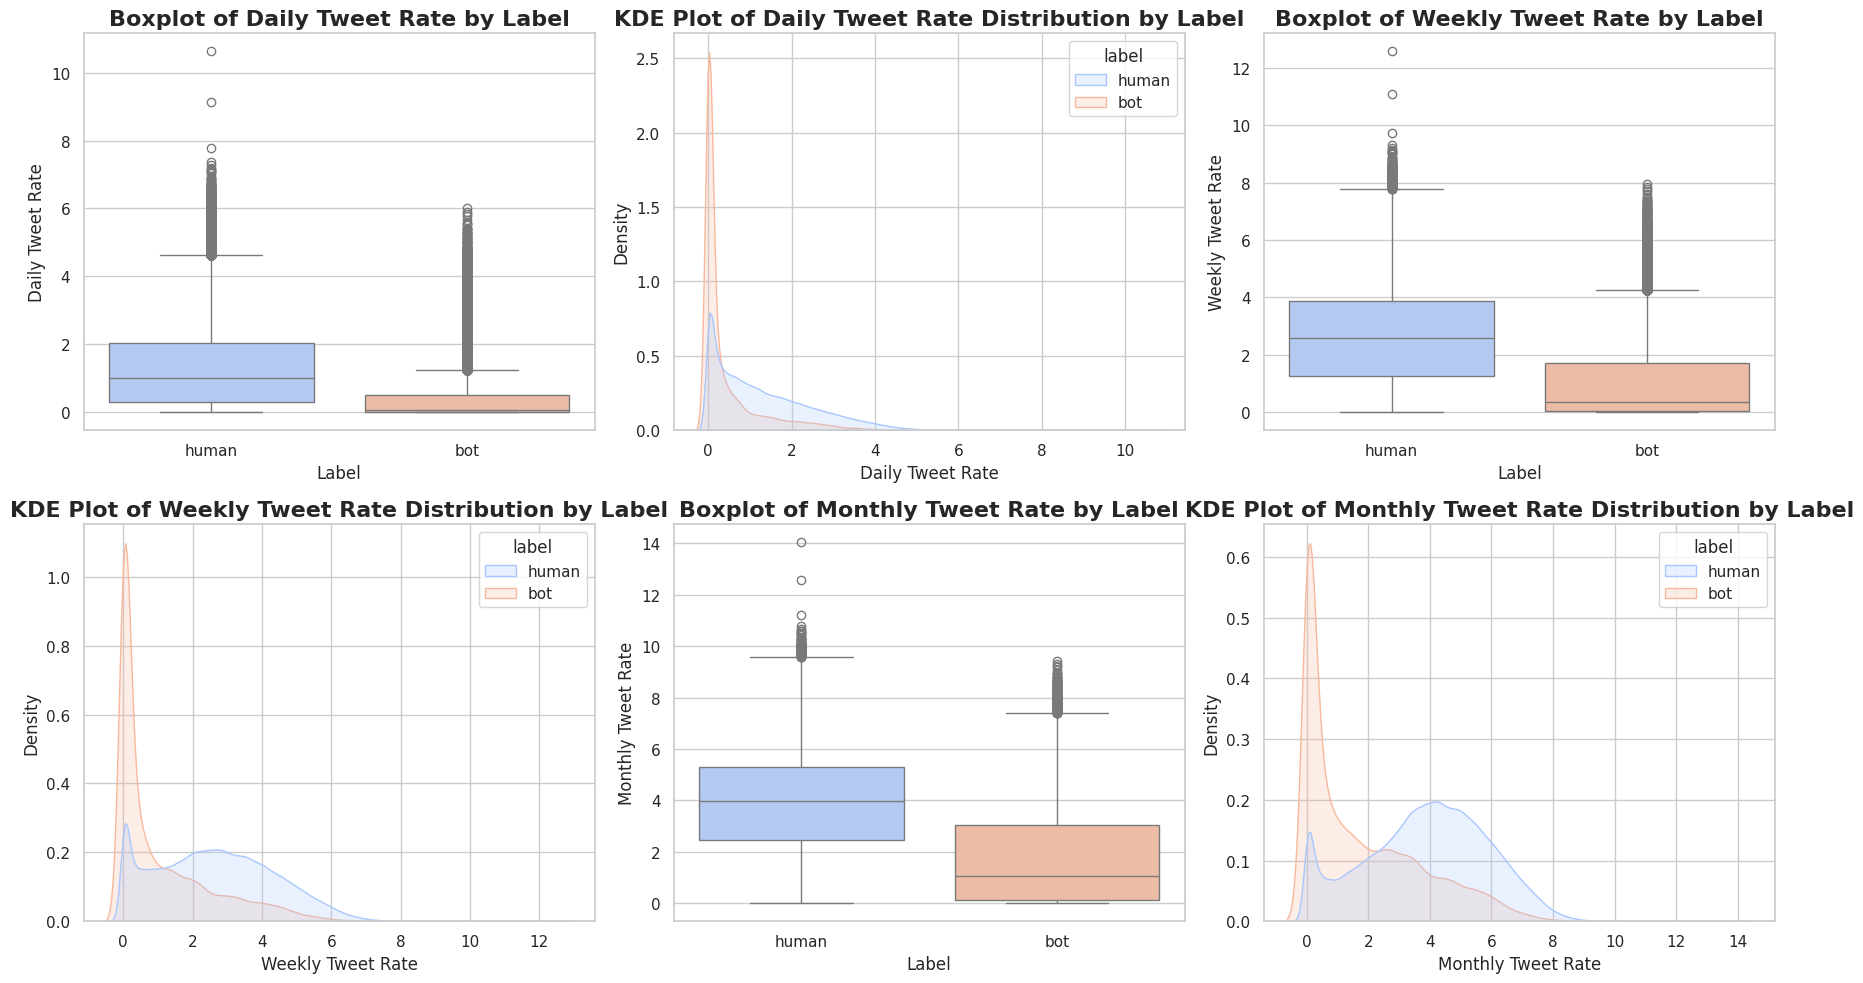

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Boxplot for daily tweet rate
sns.boxplot(x='label', y='log_tweet_rate_daily', data=user_features, palette="coolwarm", ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Daily Tweet Rate by Label', fontsize=16, weight='bold')
axes[0, 0].set_xlabel('Label', fontsize=12)
axes[0, 0].set_ylabel('Daily Tweet Rate', fontsize=12)

# KDE plot for daily tweet rate
sns.kdeplot(data=user_features, x='log_tweet_rate_daily', hue='label', fill=True, common_norm=False, palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title('KDE Plot of Daily Tweet Rate Distribution by Label', fontsize=16, weight='bold')
axes[0, 1].set_xlabel('Daily Tweet Rate', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)

# Boxplot for weekly tweet rate
sns.boxplot(x='label', y='log_tweet_rate_weekly', data=user_features, palette="coolwarm", ax=axes[0, 2])
axes[0, 2].set_title('Boxplot of Weekly Tweet Rate by Label', fontsize=16, weight='bold')
axes[0, 2].set_xlabel('Label', fontsize=12)
axes[0, 2].set_ylabel('Weekly Tweet Rate', fontsize=12)

# KDE plot for weekly tweet rate
sns.kdeplot(data=user_features, x='log_tweet_rate_weekly', hue='label', fill=True, common_norm=False, palette="coolwarm", ax=axes[1, 0])
axes[1, 0].set_title('KDE Plot of Weekly Tweet Rate Distribution by Label', fontsize=16, weight='bold')
axes[1, 0].set_xlabel('Weekly Tweet Rate', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)

# Boxplot for monthly tweet rate
sns.boxplot(x='label', y='log_tweet_rate_monthly', data=user_features, palette="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Monthly Tweet Rate by Label', fontsize=16, weight='bold')
axes[1, 1].set_xlabel('Label', fontsize=12)
axes[1, 1].set_ylabel('Monthly Tweet Rate', fontsize=12)

# KDE plot for monthly tweet rate
sns.kdeplot(data=user_features, x='log_tweet_rate_monthly', hue='label', fill=True, common_norm=False, palette="coolwarm", ax=axes[1, 2])
axes[1, 2].set_title('KDE Plot of Monthly Tweet Rate Distribution by Label', fontsize=16, weight='bold')
axes[1, 2].set_xlabel('Monthly Tweet Rate', fontsize=12)
axes[1, 2].set_ylabel('Density', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [26]:
#TODO:
# Use Entities to extract meanigful facts from description
def extract_description_entities(entities):
    if entities is None:
        return {
            'description_urls': [],
            'hashtags': [],
            'mentions': [],
            'cashtags': []
        }
    description_urls = [url_info.get('expanded_url', '') for url_info in entities.get('description', {}).get('urls', [])]
    hashtags = [hashtag_info.get('tag', '') for hashtag_info in entities.get('description', {}).get('hashtags', [])]
    mentions = [mention_info.get('tag', '') for mention_info in entities.get('description', {}).get('mentions', [])]
    cashtags = [cashtag_info.get('tag', '') for cashtag_info in entities.get('description', {}).get('cashtags', [])]

    return {
        'description_urls': description_urls,
        'hashtags': hashtags,
        'mentions': mentions,
        'cashtags': cashtags
    }

user_features['description_entities'] = user_train_df['entities'].apply(lambda x: extract_description_entities(x))

In [27]:
user_features['description_urls_count'] = user_features['description_entities'].apply(lambda x: len(x['description_urls']))
user_features['hashtag_count'] = user_features['description_entities'].apply(lambda x: len(x['hashtags']))
user_features['mention_count'] = user_features['description_entities'].apply(lambda x: len(x['mentions']))
user_features['cashtag_count'] = user_features['description_entities'].apply(lambda x: len(x['cashtags']))

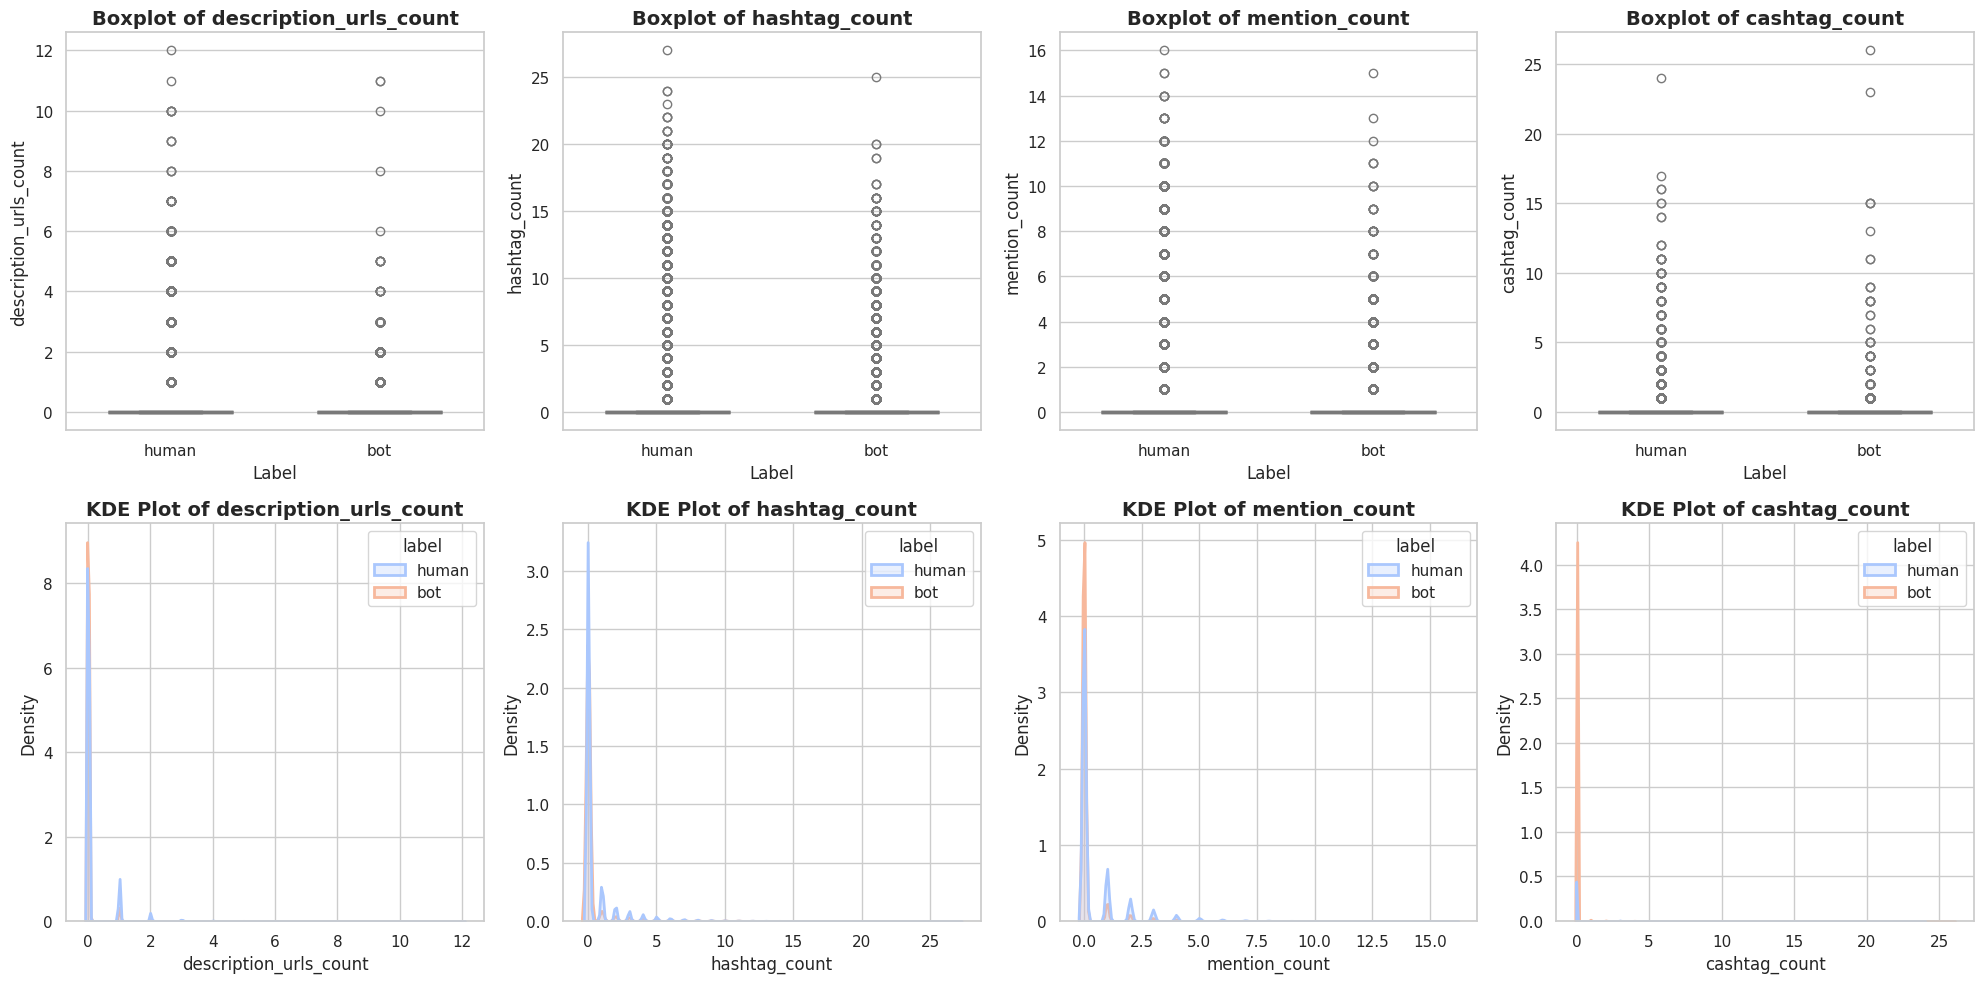

In [28]:
# Define the metrics to visualize
metrics = ['description_urls_count', 'hashtag_count', 'mention_count', 'cashtag_count']

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through metrics to create boxplots and KDE plots
for i, metric in enumerate(metrics):
    # Boxplot
    sns.boxplot(x='label', y=metric, data=user_features, palette="coolwarm", width=0.6, linewidth=2.5, ax=axes[0, i])
    axes[0, i].set_title(f'Boxplot of {metric}', fontsize=14, weight='bold')
    axes[0, i].set_xlabel('Label', fontsize=12)
    axes[0, i].set_ylabel(metric, fontsize=12)

    # KDE plot
    sns.kdeplot(data=user_features, x=metric, hue='label', fill=True, common_norm=False, palette="coolwarm", linewidth=2, ax=axes[1, i])
    axes[1, i].set_title(f'KDE Plot of {metric}', fontsize=14, weight='bold')
    axes[1, i].set_xlabel(metric, fontsize=12)
    axes[1, i].set_ylabel('Density', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [29]:
user_features['has_pinned_tweet'] = user_train_df['pinned_tweet_id'].apply(lambda x: 0 if pd.isna(x) else 1)
user_features['has_custom_profile_image'] = user_train_df['profile_image_url'].apply(lambda x: 0 if 'default_profile_images' in x else 1)

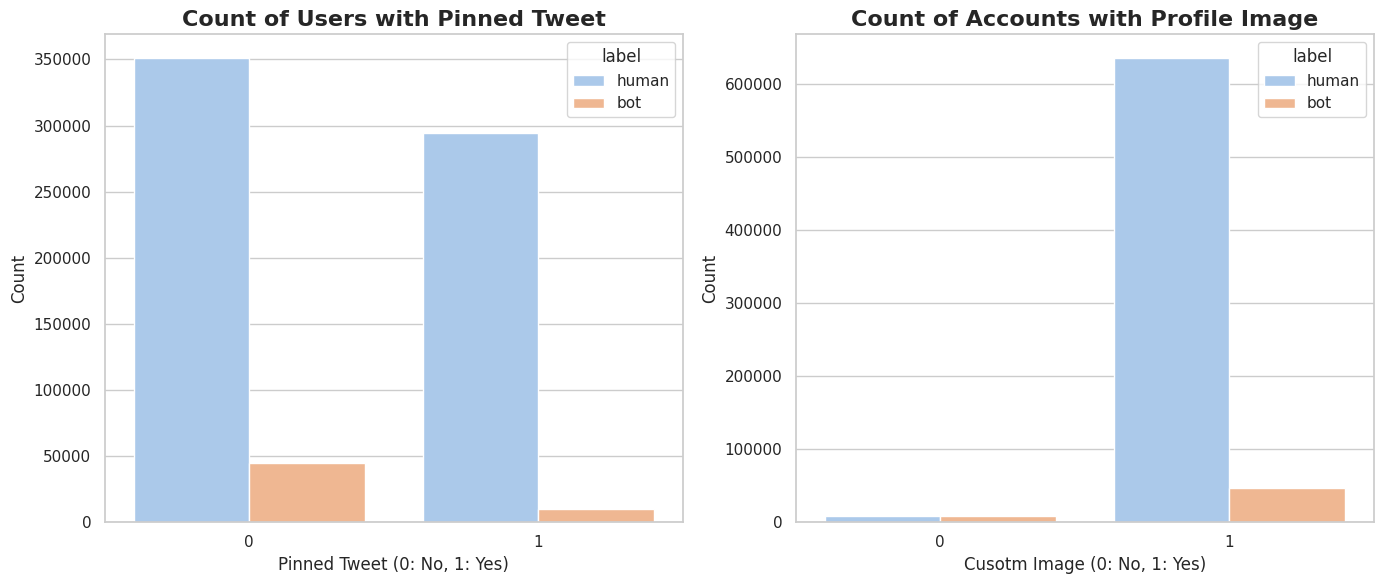

In [30]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Countplot for 'is_verified'
sns.countplot(x='has_pinned_tweet', hue='label', data=user_features, palette="pastel", ax=axes[0])
axes[0].set_title('Count of Users with Pinned Tweet', fontsize=16, weight='bold')
axes[0].set_xlabel('Pinned Tweet (0: No, 1: Yes)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Countplot for 'is_private'
sns.countplot(x='has_custom_profile_image', hue='label', data=user_features, palette="pastel", ax=axes[1])
axes[1].set_title('Count of Accounts with Profile Image', fontsize=16, weight='bold')
axes[1].set_xlabel('Cusotm Image (0: No, 1: Yes)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [31]:
user_features['name_length'] = user_train_df['name'].apply(len)
user_features['username_length'] = user_train_df['username'].apply(len)
user_features['description_length'] = user_train_df['description'].apply(len)
user_features['numDigits_username'] = user_train_df['username'].apply(lambda x: sum(c.isdigit() for c in x))

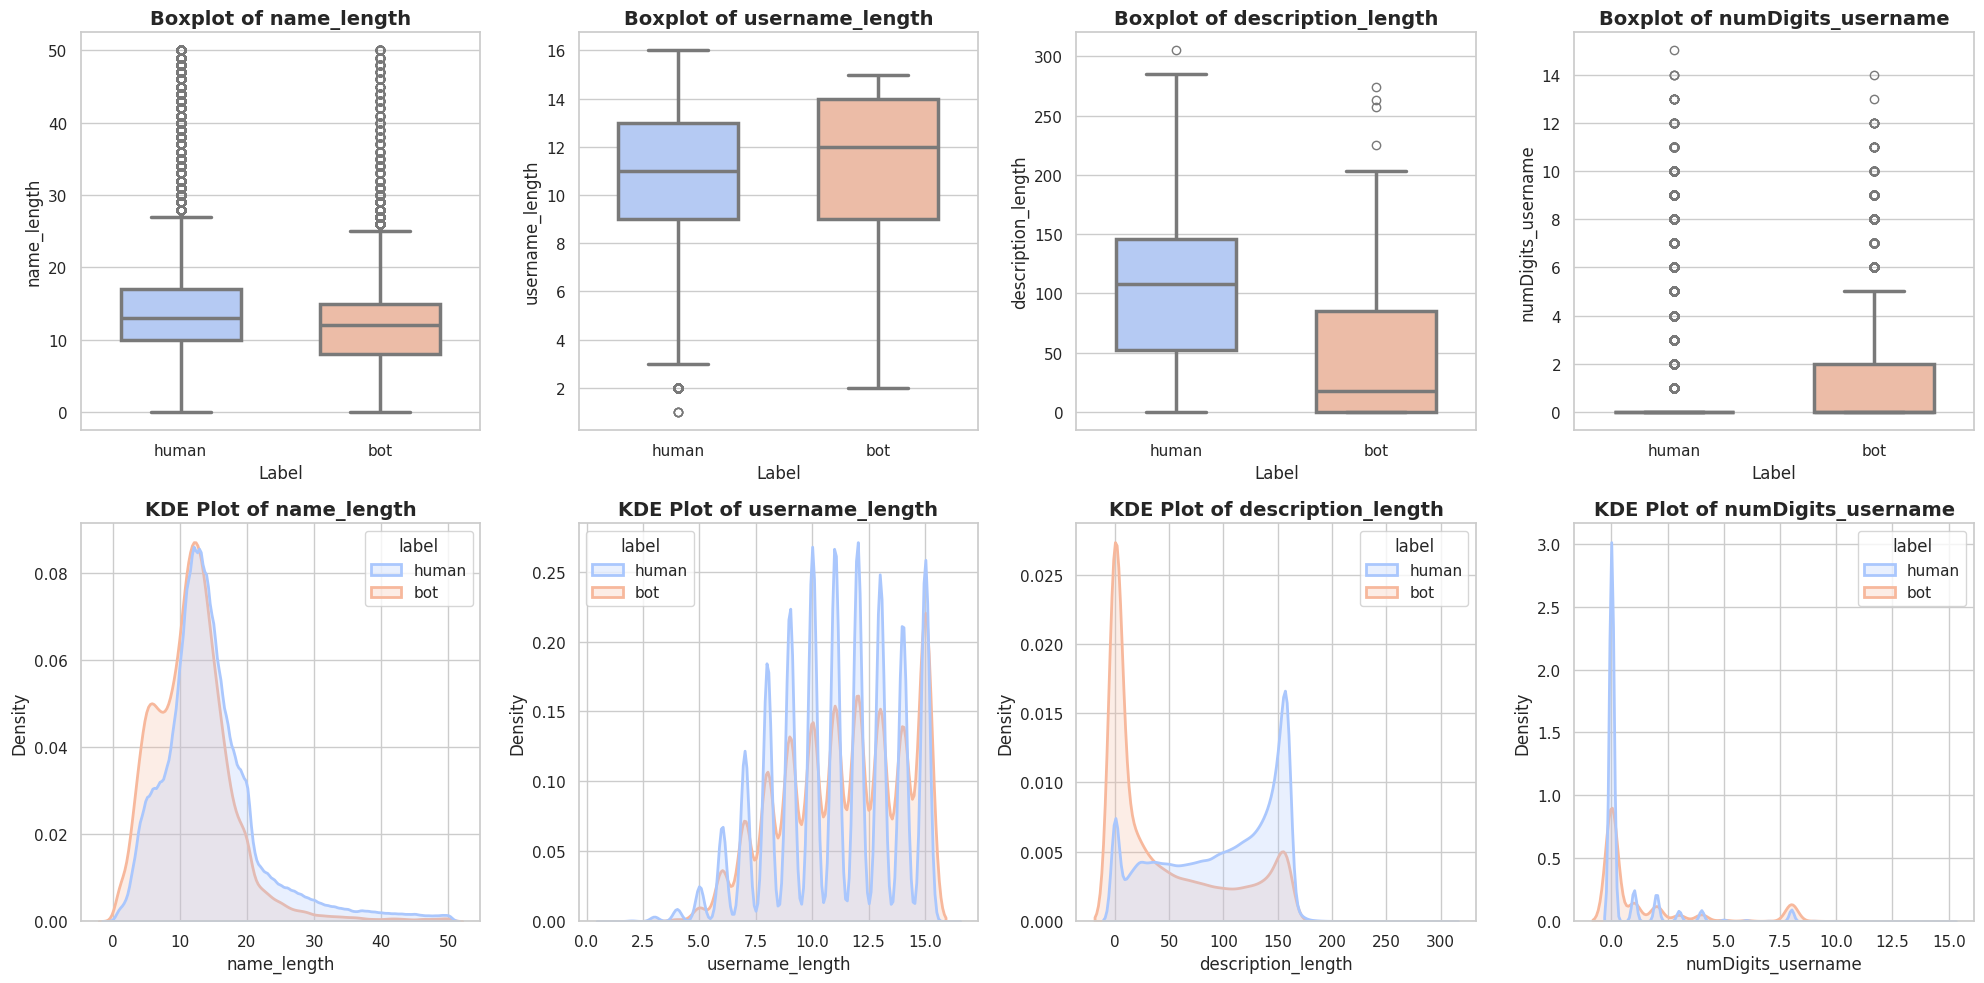

In [32]:
metrics = ['name_length', 'username_length', 'description_length', 'numDigits_username']

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through metrics to create boxplots and KDE plots
for i, metric in enumerate(metrics):
    # Boxplot
    sns.boxplot(x='label', y=metric, data=user_features, palette="coolwarm", width=0.6, linewidth=2.5, ax=axes[0, i])
    axes[0, i].set_title(f'Boxplot of {metric}', fontsize=14, weight='bold')
    axes[0, i].set_xlabel('Label', fontsize=12)
    axes[0, i].set_ylabel(metric, fontsize=12)

    # KDE plot
    sns.kdeplot(data=user_features, x=metric, hue='label', fill=True, common_norm=False, palette="coolwarm", linewidth=2, ax=axes[1, i])
    axes[1, i].set_title(f'KDE Plot of {metric}', fontsize=14, weight='bold')
    axes[1, i].set_xlabel(metric, fontsize=12)
    axes[1, i].set_ylabel('Density', fontsize=12)

# Adjust the layout for neatness
plt.tight_layout()

# Show the plots
plt.show()

In [33]:
user_test_df = user_data_with_label[user_data_with_label['id'].isin(test_ids)]

In [34]:
user_val_df = user_data_with_label[user_data_with_label['id'].isin(val_ids)]

In [35]:
def transform(dataset):
    user_features = pd.DataFrame(dataset[['id','label']])
    
    current_date = datetime.now(pytz.UTC)
    user_features['account_age'] = dataset['created_at'].apply(lambda x: (current_date - x).days / 365.25)
    user_features['account_age'] = user_features['account_age'].apply(lambda x: np.nan if x > 19 else x)
    user_features['account_age'] = user_features.groupby('label')['account_age'].transform(lambda grp: grp.fillna(grp.mean()))
    
    user_features['followers_count'] = dataset['public_metrics'].apply(lambda x: x.get('followers_count', 0))
    user_features['following_count'] = dataset['public_metrics'].apply(lambda x: x.get('following_count', 0))
    user_features['tweet_count'] = dataset['public_metrics'].apply(lambda x: x.get('tweet_count', 0))
    user_features['listed_count'] = dataset['public_metrics'].apply(lambda x: x.get('listed_count', 0))
    user_features['log_followers_count'] = np.log1p(user_features['followers_count'])
    user_features['log_following_count'] = np.log1p(user_features['following_count'])
    user_features['log_tweet_count'] = np.log1p(user_features['tweet_count'])
    user_features['log_listed_count'] = np.log1p(user_features['listed_count'])
    user_features['follower_following_ratio'] = user_features['followers_count'] / (user_features['following_count'] + 1)
    user_features['log_follower_following_ratio'] = np.log1p(user_features['follower_following_ratio'])
    
    user_features['is_verified'] = dataset['verified'].astype(int)
    user_features['is_private'] = dataset['protected'].astype(int)
    
    user_features['tweet_rate_daily'] = user_features['tweet_count'] / (user_features['account_age'] * 365.25)
    user_features['tweet_rate_weekly'] = user_features['tweet_count'] / (user_features['account_age'] * 52)
    user_features['tweet_rate_monthly'] = user_features['tweet_count'] / (user_features['account_age'] * 12)
    user_features['log_tweet_rate_daily'] = np.log1p(user_features['tweet_rate_daily'])  # log(1 + x)
    user_features['log_tweet_rate_weekly'] = np.log1p(user_features['tweet_rate_weekly'])
    user_features['log_tweet_rate_monthly'] = np.log1p(user_features['tweet_rate_monthly'])
    
    user_features['description_entities'] = dataset['entities'].apply(lambda x: extract_description_entities(x))
    user_features['description_urls_count'] = user_features['description_entities'].apply(lambda x: len(x['description_urls']))
    user_features['hashtag_count'] = user_features['description_entities'].apply(lambda x: len(x['hashtags']))
    user_features['mention_count'] = user_features['description_entities'].apply(lambda x: len(x['mentions']))
    user_features['cashtag_count'] = user_features['description_entities'].apply(lambda x: len(x['cashtags']))
    
    user_features['has_pinned_tweet'] = dataset['pinned_tweet_id'].apply(lambda x: 0 if pd.isna(x) else 1)
    user_features['has_custom_profile_image'] = dataset['profile_image_url'].apply(lambda x: 0 if 'default_profile_images' in x else 1)
    
    user_features['name_length'] = dataset['name'].apply(len)
    user_features['username_length'] = dataset['username'].apply(len)
    user_features['description_length'] = dataset['description'].apply(len)
    user_features['numDigits_username'] = dataset['username'].apply(lambda x: sum(c.isdigit() for c in x))
    
    return user_features

In [36]:
user_features_train = transform(user_train_df)
user_features_val = transform(user_val_df)
user_features_test = transform(user_test_df)

In [37]:
def filterData(dataset,remove_correlated_features=False):
    df = dataset.copy()
    df.drop(columns=['id','description_entities'],inplace=True)
    if remove_correlated_features:
        df.drop(columns=['followers_count','following_count','tweet_count','listed_count','follower_following_ratio','tweet_rate_daily','tweet_rate_weekly','tweet_rate_monthly'],inplace=True)   
    return df

In [38]:
user_features_train_ready = filterData(user_features_train)
user_features_test_ready = filterData(user_features_test)
user_features_val_ready = filterData(user_features_val)

# Experimental Setup 
- RF with all features and samples
- RF with all features and Downsample
- RF with subset of feature and all sample
- RF with subset of feature all downsample
- Hypeparameter tuning of best RF

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [40]:
def training(Train_Data,Test_Data,Val_Data):
    X_train = Train_Data.drop('label',axis=1)
    y_train = Train_Data['label']
    X_test = Test_Data.drop('label',axis=1)
    y_test = Test_Data['label']
    X_val = Val_Data.drop('label',axis=1)
    y_val = Val_Data['label']
    rf_classifier = RandomForestClassifier(n_jobs=-1,random_state=42)
    print("Training...")
    rf_classifier.fit(X_train, y_train)
    print("Training Complete")

    importances = rf_classifier.feature_importances_
    # If you have feature names (assuming X is a DataFrame)
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    print(feature_importance_df)
    
    y_val_pred = rf_classifier.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
    y_test_pred = rf_classifier.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

    # Optionally, view the confusion matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

In [41]:
training(user_features_train_ready,user_features_test_ready,user_features_val_ready)

Training...
Training Complete
                         feature  importance
27            description_length    0.079814
5            log_followers_count    0.070850
1                followers_count    0.070294
10  log_follower_following_ratio    0.063016
0                    account_age    0.061331
9       follower_following_ratio    0.060723
2                following_count    0.055352
6            log_following_count    0.054927
7                log_tweet_count    0.045745
25                   name_length    0.043753
3                    tweet_count    0.043519
15            tweet_rate_monthly    0.038062
14             tweet_rate_weekly    0.037749
18        log_tweet_rate_monthly    0.037686
16          log_tweet_rate_daily    0.037452
17         log_tweet_rate_weekly    0.037057
13              tweet_rate_daily    0.036974
26               username_length    0.031115
4                   listed_count    0.019860
8               log_listed_count    0.019364
28            numDigits_u

In [42]:
human_sample = user_features_train_ready[user_features_train_ready['label'] == 'human'].sample(n=80000, random_state=42)
bot_all = user_features_train_ready[user_features_train_ready['label'] == 'bot']
user_features_train_reduced = pd.concat([human_sample, bot_all])
user_features_train_reduced = user_features_train_reduced.sample(frac=1, random_state=42).reset_index(drop=True)

In [43]:
training(user_features_train_reduced,user_features_test_ready,user_features_val_ready)

Training...
Training Complete
                         feature  importance
5            log_followers_count    0.100745
1                followers_count    0.094038
10  log_follower_following_ratio    0.067492
7                log_tweet_count    0.067149
27            description_length    0.066609
9       follower_following_ratio    0.064606
3                    tweet_count    0.053196
0                    account_age    0.045316
2                following_count    0.045210
6            log_following_count    0.044501
15            tweet_rate_monthly    0.033220
25                   name_length    0.033012
14             tweet_rate_weekly    0.031473
4                   listed_count    0.030949
13              tweet_rate_daily    0.030539
16          log_tweet_rate_daily    0.030486
8               log_listed_count    0.029527
17         log_tweet_rate_weekly    0.029380
18        log_tweet_rate_monthly    0.029064
26               username_length    0.023447
28            numDigits_u

In [47]:
def train_model(Train_Data):
    X_train = Train_Data.drop('label', axis=1)
    y_train = Train_Data['label']
    
    # Define the parameter grid for Grid Search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    
    print("Training with Grid Search...")
    grid_search.fit(X_train, y_train)
    print("Grid Search Complete")
    
    # Get the best estimator from grid search
    best_rf_classifier = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)
    
    return best_rf_classifier

# Function to print feature importance
def print_feature_importance(model, X_train):
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    print(feature_importance_df)

# Function to print accuracy reports
def print_accuracy_reports(model,Train_Data, Test_Data, Val_Data):
    X_train = Train_Data.drop('label',axis=1)
    y_train = Train_Data['label']
    X_test = Test_Data.drop('label', axis=1)
    y_test = Test_Data['label']
    X_val = Val_Data.drop('label', axis=1)
    y_val = Val_Data['label']

    # Training Predictions
    y_train_pred = model.predict(X_train)
    print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
    
    # Validation Predictions
    y_val_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
    
    # Test Predictions
    y_test_pred = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


In [45]:
best_model = train_model(user_features_train_reduced)

Training with Grid Search...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  45.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  27.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.7min


/home1/rachita/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.0min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  46.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  28.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  45.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  28.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.0min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total

/home1/rachita/.local/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Grid Search Complete
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [46]:
best_model

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  42.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  39.4s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.7min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  42.2s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  40.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  43.0s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  33.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total

In [48]:
print_accuracy_reports(best_model, user_features_train_reduced, user_features_test_ready, user_features_val_ready)

Training Accuracy: 0.9011709984693802
Training Classification Report:
               precision    recall  f1-score   support

         bot       0.89      0.86      0.88     54586
       human       0.91      0.93      0.92     80000

    accuracy                           0.90    134586
   macro avg       0.90      0.89      0.90    134586
weighted avg       0.90      0.90      0.90    134586

Validation Accuracy: 0.61577
Validation Classification Report:
               precision    recall  f1-score   support

         bot       0.40      0.72      0.51     55913
       human       0.84      0.58      0.68    144087

    accuracy                           0.62    200000
   macro avg       0.62      0.65      0.60    200000
weighted avg       0.72      0.62      0.64    200000

Test Accuracy: 0.62606
Test Classification Report:
               precision    recall  f1-score   support

         bot       0.43      0.77      0.55     29444
       human       0.85      0.57      0.68     70

In [49]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

In [50]:
X_train = user_features_train_reduced.drop("label",axis =1 )
y_train = label_encoder.fit_transform(user_features_train_reduced['label'])
X_val = user_features_val_ready.drop("label",axis =1 )
y_val = label_encoder.fit_transform(user_features_val_ready['label'])
X_test = user_features_test_ready.drop("label",axis =1 )
y_test = label_encoder.fit_transform(user_features_test_ready['label'])

In [51]:
train_data = lgb.Dataset(X_train, label= y_train)
val_data = lgb.Dataset(X_val, label= y_val, reference=train_data)
test_data = lgb.Dataset(X_test, label= y_test, reference=train_data)

In [52]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
}

# Train the model
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Info] Number of positive: 80000, number of negative: 54586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4676
[LightGBM] [Info] Number of data points in the train set: 134586, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594415 -> initscore=0.382249
[LightGBM] [Info] Start training from score 0.382249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.606727


In [54]:
y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_val, y_pred_binary))

# Optional: Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred_binary)


Accuracy: 0.6725
              precision    recall  f1-score   support

           0       0.44      0.59      0.50     55913
           1       0.82      0.70      0.76    144087

    accuracy                           0.67    200000
   macro avg       0.63      0.65      0.63    200000
weighted avg       0.71      0.67      0.69    200000



In [186]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx

In [195]:
edges = pd.read_csv("Filtered-Edges.csv")

In [197]:
relation_mapping = {'followers': 0, 'following': 1}

# Apply the mapping to convert relations to integers
edges['relation'] = edges['relation'].map(relation_mapping)

In [187]:
all_nodes = pd.concat([user_features_train, user_features_val, user_features_test])

In [189]:
label_mapping = {'human': 0, 'bot': 1}
all_nodes['label'] = all_nodes['label'].map(label_mapping)

In [192]:
node_features = torch.tensor(all_nodes.drop(['id', 'label','description_entities'], axis=1).values, dtype=torch.float)

In [193]:
node_map = {node_id: idx for idx, node_id in enumerate(all_nodes['id'])}

In [198]:
# Create edge index tensor (2 x num_edges)
edge_index = torch.tensor([edges['source_id'].map(node_map), edges['target_id'].map(node_map)], dtype=torch.long)

# Create edge relation tensor (num_edges,)
edge_type = torch.tensor(edges['relation'].values, dtype=torch.long)

In [200]:
from torch_geometric.data import Data

# Create the graph
data = Data(x=node_features, edge_index=edge_index, edge_type=edge_type, y=labels)

# Optional: Specify train/val/test masks if necessary
num_nodes = all_nodes.shape[0]
train_idx = torch.arange(len(user_features_train))
val_idx = torch.arange(len(user_features_train), len(user_features_train) + len(user_features_val))
test_idx = torch.arange(len(user_features_train) + len(user_features_val), num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = 1
data.val_mask[val_idx] = 1
data.test_mask[test_idx] = 1

In [201]:
from torch_geometric.nn import RGCNConv

class RGCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_rels):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(in_channels, 16, num_rels, num_bases=40)
        self.conv2 = RGCNConv(16, out_channels, num_rels, num_bases=30)

    def forward(self, data):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        x = self.conv1(x, edge_index, edge_type)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

In [202]:
model = RGCN(in_channels=data.num_node_features, out_channels=2, num_rels=edge_type.max().item() + 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data)

    # Compute loss only for training nodes
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 109840.3984375
Epoch 1, Loss: 36470.5
Epoch 2, Loss: 42646.97265625
Epoch 3, Loss: 42218.125
Epoch 4, Loss: 27453.060546875
Epoch 5, Loss: 23794.515625
Epoch 6, Loss: 28282.525390625
Epoch 7, Loss: 29965.044921875
Epoch 8, Loss: 29401.306640625
Epoch 9, Loss: 27591.732421875
Epoch 10, Loss: 25390.978515625
Epoch 11, Loss: 21642.857421875
Epoch 12, Loss: 17979.037109375
Epoch 13, Loss: 14809.771484375
Epoch 14, Loss: 11524.0078125
Epoch 15, Loss: 8457.2646484375
Epoch 16, Loss: 7988.361328125
Epoch 17, Loss: 7073.849609375
Epoch 18, Loss: 5767.2119140625
Epoch 19, Loss: 6012.63818359375
Epoch 20, Loss: 5110.53955078125
Epoch 21, Loss: 3766.590576171875
Epoch 22, Loss: 3992.151123046875
Epoch 23, Loss: 4298.4052734375
Epoch 24, Loss: 4322.88330078125
Epoch 25, Loss: 4109.9873046875
Epoch 26, Loss: 3702.99951171875
Epoch 27, Loss: 3169.143310546875
Epoch 28, Loss: 2472.16015625
Epoch 29, Loss: 1753.879638671875
Epoch 30, Loss: 3927.192138671875
Epoch 31, Loss: 2391.3671875


In [204]:
def evaluate_with_report(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].argmax(dim=1)  # Predicted labels
        true_labels = data.y[mask]  # True labels
        
        # Compute accuracy
        correct = pred.eq(true_labels)
        acc = correct.sum().item() / mask.sum().item()
        
        # Generate classification report
        report = classification_report(true_labels.cpu(), pred.cpu(), target_names=['human', 'bot'])
    
    return acc, report

# Evaluate on validation and test sets
val_acc, val_report = evaluate_with_report(model, data, data.val_mask)
test_acc, test_report = evaluate_with_report(model, data, data.test_mask)

print(f"Validation Accuracy: {val_acc}")
print(f"Validation Classification Report:\n{val_report}")

print(f"Test Accuracy: {test_acc}")
print(f"Test Classification Report:\n{test_report}")

Validation Accuracy: 0.703485
Validation Classification Report:
              precision    recall  f1-score   support

       human       0.72      0.97      0.82    144087
         bot       0.23      0.03      0.05     55913

    accuracy                           0.70    200000
   macro avg       0.48      0.50      0.44    200000
weighted avg       0.58      0.70      0.61    200000

Test Accuracy: 0.69129
Test Classification Report:
              precision    recall  f1-score   support

       human       0.70      0.97      0.82     70556
         bot       0.20      0.02      0.03     29444

    accuracy                           0.69    100000
   macro avg       0.45      0.49      0.42    100000
weighted avg       0.56      0.69      0.58    100000

